In [1]:
from Format import *
from config import *
import pandas as pd
"""
df = pd.read_excel(f"{path_unify}2023-11-15_df.xlsx")

data = DistanceCalculator().calcular_distancias(df)
data = DataFilter().formatDF(data)
data.to_csv("../Data/test/filt_11_15.csv", sep=";", index=False)
"""
data = pd.read_csv("../Data/test/filt_11_15.csv", sep=";")
data = data.loc[data["tipoPropiedad"] != 3]

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['tipoPropiedad', 'terrenoEdificado', 
            'cantDormitorios', 'cantBanos',
            'barrioID', 'coordX', 'coordY', 
            'transporteCercano', 'saludCercana', 
            'ano', 'mes']
data_analisis = data[features]
target = data["precioUSD"]

X_train, X_test, y_train, y_test = train_test_split(data_analisis, target, train_size=0.8, random_state=33)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [3]:
models = dict()
r2_scores = []
for i in range(1, 20):
    models[f'knn{i}'] = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m.fit(X_train_scaled, y_train)
    scores_r2 = cross_val_score(m, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_scores.append((f'knn{i}', scores_r2.mean()))
    
r2_scores

[('knn1', 0.5938836378448819),
 ('knn2', 0.6665850478021366),
 ('knn3', 0.6949455551539092),
 ('knn4', 0.7065419116137566),
 ('knn5', 0.7174647980046683),
 ('knn6', 0.7220272260279385),
 ('knn7', 0.7241788999149097),
 ('knn8', 0.7235720672643339),
 ('knn9', 0.7247534929027308),
 ('knn10', 0.7254787913334135),
 ('knn11', 0.7261656761444707),
 ('knn12', 0.7263646025136635),
 ('knn13', 0.7255714172441461),
 ('knn14', 0.724765047036232),
 ('knn15', 0.7245250603477744),
 ('knn16', 0.7234867170085616),
 ('knn17', 0.7223264845682719),
 ('knn18', 0.7207328154929743),
 ('knn19', 0.7188572184852564)]

In [30]:
from sklearn.ensemble import RandomForestRegressor

print("Creando Random Forest...")

best_depth = 16

random_forest_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=best_depth)
random_forest_model.fit(X_train_scaled, y_train)
best_r2 = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()
    
models['RF'] = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=best_depth)

r2_scores.append(('RF', best_r2))
print(f"Random Forest: r2 = {best_r2}, depth = {best_depth}")

Creando Random Forest...
Random Forest: r2 = 0.7516126472602958, depth = 16


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

print("Creando XGBoost...")

best_depth = 6

gradient_boosting_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=best_depth, random_state=42)
gradient_boosting_model.fit(X_train_scaled, y_train)
best_r2 = cross_val_score(gradient_boosting_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

models['GBX'] = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=best_depth)

r2_scores.append(('GBX', best_r2))
print(f"XGBoost: r2 = {best_r2}, depth = {best_depth}")

Creando XGBoost...
XGBoost: r2 = 0.7658254176396608, depth = 6


In [32]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

print("Creando AdaBoost con Decision Tree...")

best_depth = 11

ada_boost_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=best_depth), n_estimators=200, random_state=42)
ada_boost_model.fit(X_train_scaled, y_train)
best_r2 = cross_val_score(ada_boost_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

models['ABX-DT'] = AdaBoostRegressor(DecisionTreeRegressor(max_depth=best_depth), n_estimators=200, random_state=42)

r2_scores.append(('ABX-DT', best_r2))
print(f"AdaBoost DT: r2 = {best_r2}, depth = {best_depth}")

Creando AdaBoost con Decision Tree...
AdaBoost DT: r2 = 0.7572579218961825, depth = 11


In [20]:
r2_scores = sorted(r2_scores, key=lambda x: x[1], reverse=True)
r2_scores = [m for m in r2_scores if m[1] > 0.75]
r2_scores

[('GBX', 0.7658254176396608),
 ('ABX-DT', 0.7572579218961825),
 ('RF', 0.7516126472602958)]

In [21]:
# modelos en r2_scores
top_models = dict()

for m in r2_scores:
    top_models[m[0]] = models[m[0]]

top_models

{'GBX': RandomForestRegressor(max_depth=6, n_estimators=200, random_state=42),
 'ABX-DT': AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=11),
                   n_estimators=200, random_state=42),
 'RF': RandomForestRegressor(max_depth=16, n_estimators=200, random_state=42)}

In [22]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("Creando Voting...")
voting_model = VotingRegressor(estimators=list(top_models.items()))
voting_model.fit(X_train_scaled, y_train)
r2 = cross_val_score(voting_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

print(f"Voting: r2 = {r2}")

X_test_scaled = scaler.transform(X_test)
voting_preds = voting_model.predict(X_test_scaled)
r2_ensamble = r2_score(y_test, voting_preds)
rmse_ensamble = np.sqrt(mean_squared_error(y_test, voting_preds))

print(f"Voting: r2 = {r2_ensamble}, rmse = {rmse_ensamble}")

Creando Voting...
Voting: r2 = 0.750622925836752


In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from scipy.optimize import minimize

def objective(weights):
    weights_dict = dict(zip(top_models.keys(), weights))
    weighted_ensemble = VotingRegressor(estimators=list(top_models.items()), weights=list(weights_dict.values()))
    weighted_ensemble.fit(X_train, y_train)
    r2 = cross_val_score(weighted_ensemble, X_train, y_train, cv=5, scoring='r2').mean()
    print(f"r2 = {r2}, weights = {weights}")
    return -r2

initial_weights = np.ones(len(top_models)) / len(top_models)

constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})

result = minimize(objective, initial_weights, constraints=constraints)

optimal_weights = result.x


r2 = 0.7491082483039502, weights = [0.33333333 0.33333333 0.33333333]
r2 = 0.7491082479370841, weights = [0.33333335 0.33333333 0.33333333]
r2 = 0.7491082485651605, weights = [0.33333333 0.33333335 0.33333333]
r2 = 0.749108248409606, weights = [0.33333333 0.33333333 0.33333335]
r2 = 0.7500431345886537, weights = [0.30871337 0.35086286 0.34042378]
r2 = 0.7500431342298051, weights = [0.30871338 0.35086286 0.34042378]
r2 = 0.7500431348194658, weights = [0.30871337 0.35086287 0.34042378]
r2 = 0.7500431346761858, weights = [0.30871337 0.35086286 0.34042379]
r2 = 0.7536666644199346, weights = [0.19282263 0.43284906 0.37432831]
r2 = 0.7536666641217709, weights = [0.19282265 0.43284906 0.37432831]
r2 = 0.7536666645309521, weights = [0.19282263 0.43284907 0.37432831]
r2 = 0.75366666444515, weights = [0.19282263 0.43284906 0.37432832]
r2 = 0.7571773493683701, weights = [-0.07975606  0.62394188  0.45581418]
r2 = 0.7571773493615982, weights = [-0.07975604  0.62394188  0.45581418]
r2 = 0.7571773493

In [28]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("Creando Voting...")
voting_model = VotingRegressor(estimators=list(top_models.items()), weights=list(optimal_weights))
voting_model.fit(X_train_scaled, y_train)
r2 = cross_val_score(voting_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

print(f"Voting: r2 = {r2}")

X_test_scaled = scaler.transform(X_test)
voting_preds = voting_model.predict(X_test_scaled)
r2_ensamble = r2_score(y_test, voting_preds)
rmse_ensamble = np.sqrt(mean_squared_error(y_test, voting_preds))

print(f"Voting: r2 = {r2_ensamble}, rmse = {rmse_ensamble}")

Creando Voting...
Voting: r2 = 0.7600333999826819
Voting: r2 = 0.7682449804913212, rmse = 41134.84274785817


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(


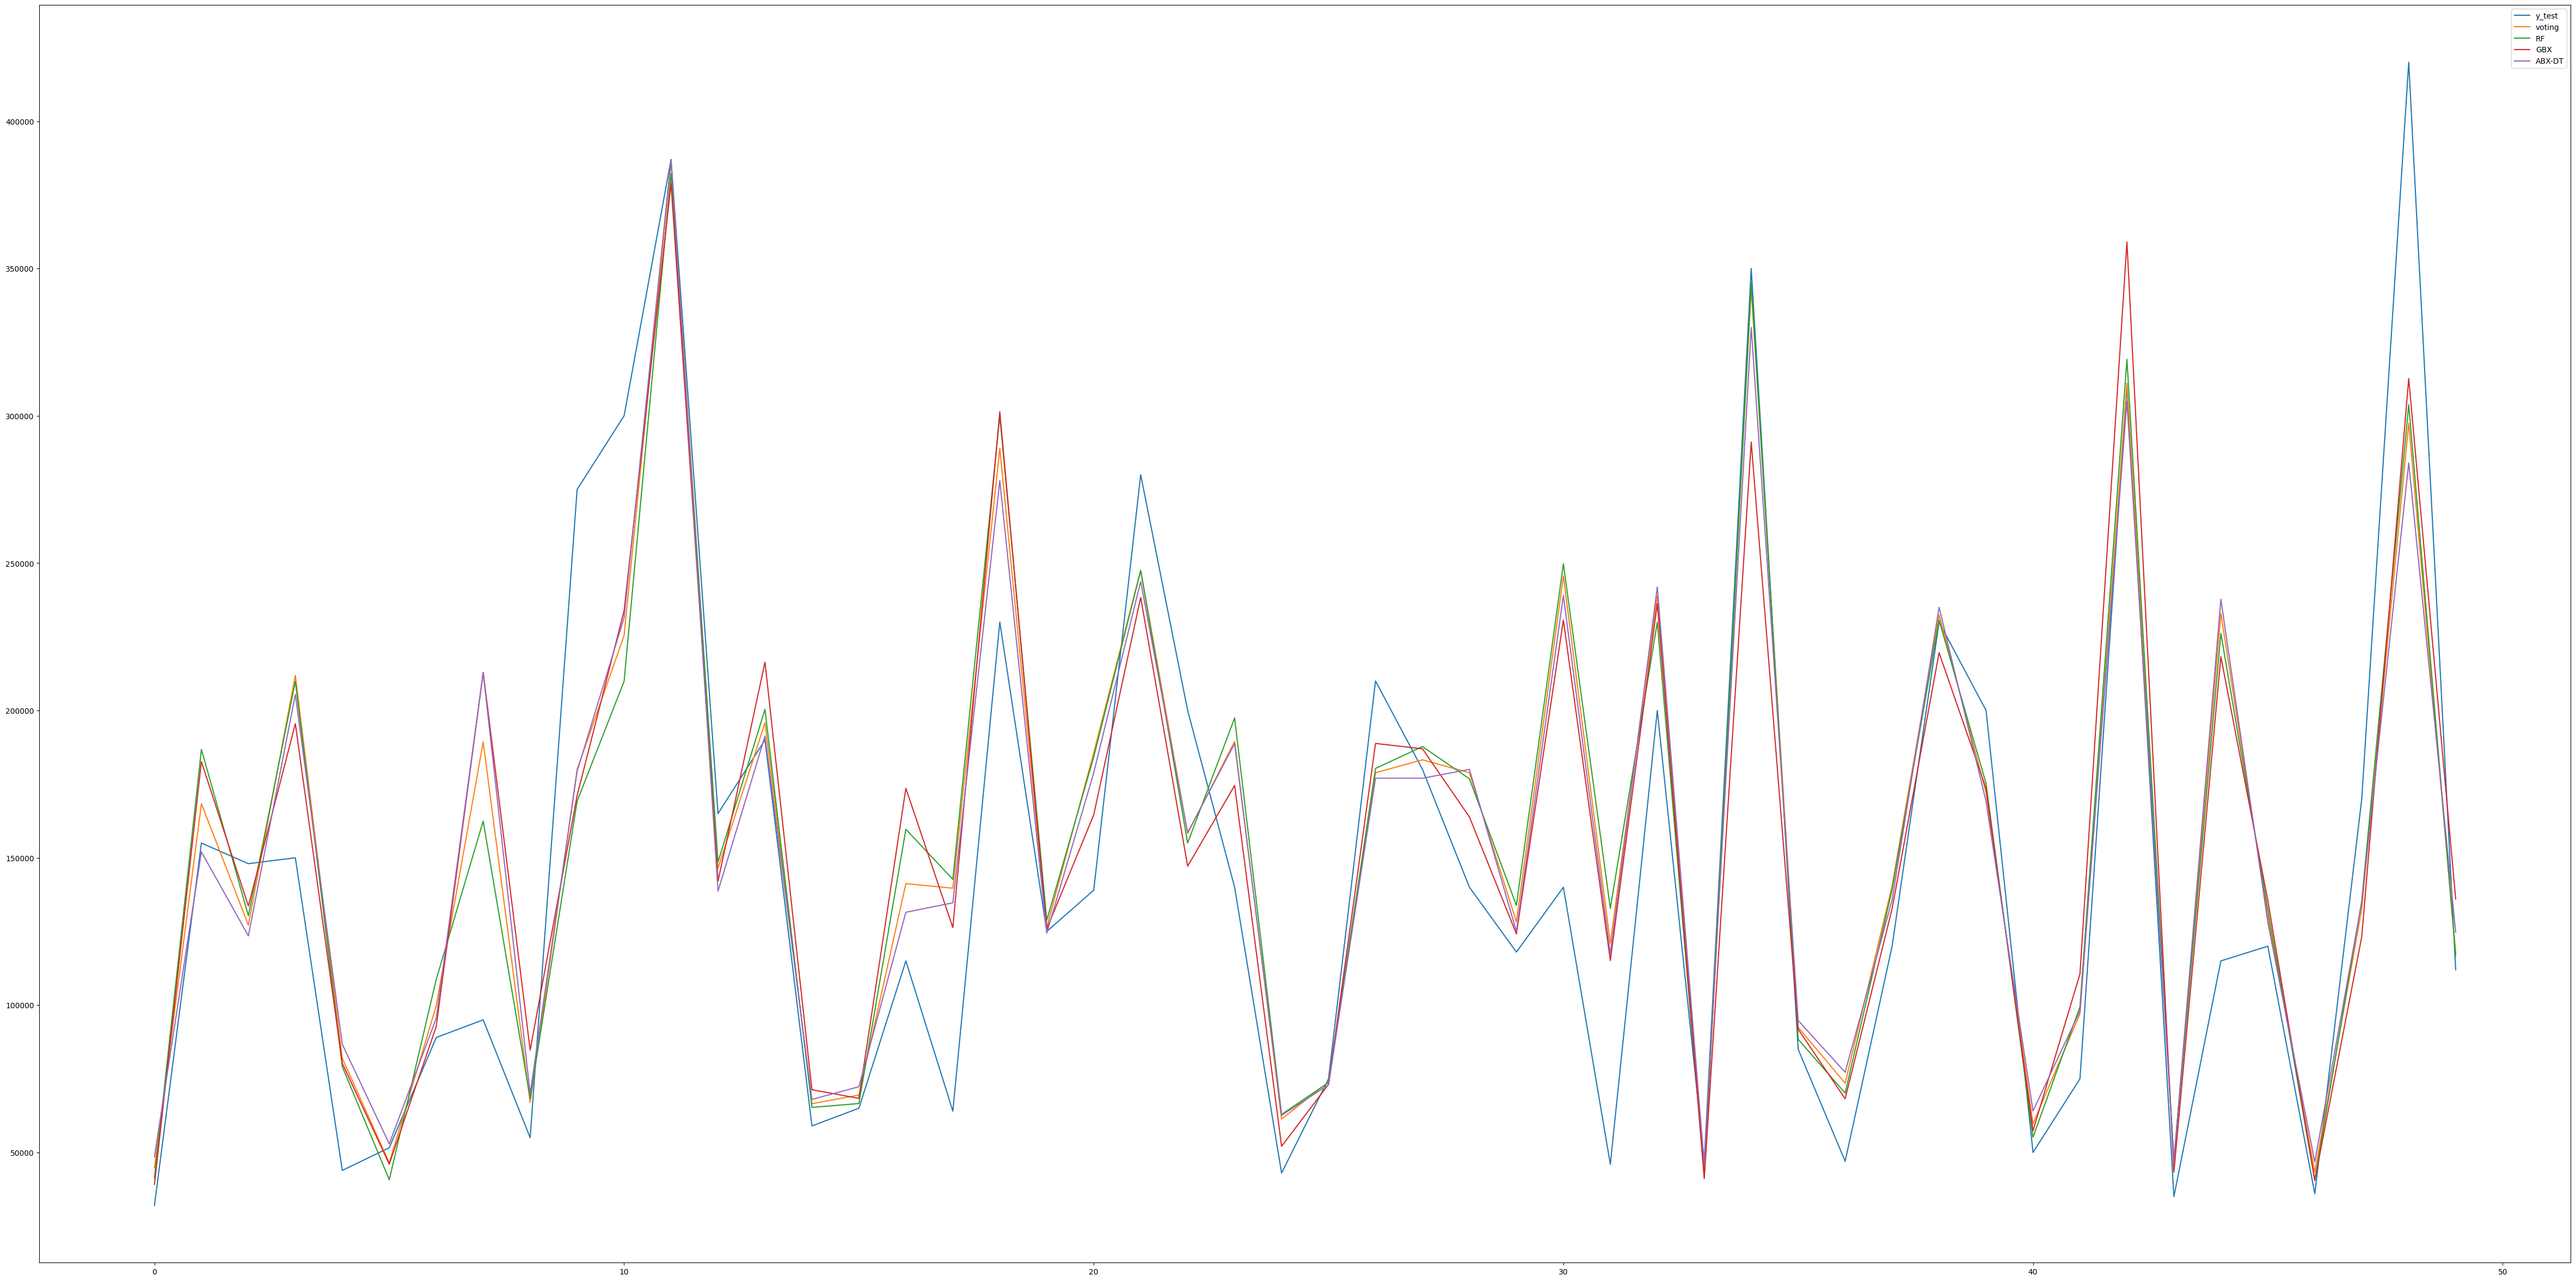

In [89]:
# Graficar y_test, predicciones de cada modelo y predicciones del ensamble
import matplotlib.pyplot as plt

rf_preds = random_forest_model.predict(X_test_scaled)
gbx_preds = gradient_boosting_model.predict(X_test_scaled)
abx_dt_preds = ada_boost_model.predict(X_test_scaled)

plt.figure(figsize=(60, 30))
plt.plot(y_test.values[:50], label='y_test')
plt.plot(voting_preds[:50], label='voting')
plt.plot(rf_preds[:50], label='RF')
plt.plot(gbx_preds[:50], label='GBX')
plt.plot(abx_dt_preds[:50], label='ABX-DT')
plt.legend()
plt.show()